In [1]:
import pandas as pd
import numpy as np

# load the data
file_url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
df = pd.read_csv(file_url)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
# select relevant data
relevant_proximities = ['<1H OCEAN','INLAND']
df = df[df['ocean_proximity'].isin(relevant_proximities)]

#### Preparation

In [3]:
# Fill missing values with zeros.
df.fillna(0, inplace=True)

# Apply the log tranform to median_house_value.
df['median_house_value'] = np.log1p(df.median_house_value)

# Do train/validation/test split with 60%/20%/20% distribution.
from sklearn.model_selection import train_test_split
## shuffle the dataset using seed 42
# n = len(df)
# idx = np.arange(n)
# np.random.seed(42)
# np.random.shuffle(idx)
# df_shuffled = df.iloc[idx]

# Use the train_test_split function and set the random_state parameter to 1.
# split the data into train/val/test with 60%/20%/20%
df_full, df_test = train_test_split(df, test_size=np.round(len(df)*.2).astype(int), random_state=1)
df_train, df_val = train_test_split(df_full, test_size=np.round(len(df)*.2).astype(int), random_state=1)

df_full = df_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [4]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
from sklearn.feature_extraction import DictVectorizer

In [5]:
features = df_train.columns.to_list()
df_train_dict=df_train[features].to_dict(orient='records')
df_val_dict=df_val[features].to_dict(orient='records')
df_test_dict=df_test[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(df_train_dict)

DictVectorizer(sparse=False)

In [6]:
X_train = dv.transform(df_train_dict)
X_val = dv.transform(df_val_dict)
X_test = dv.transform(df_test_dict)

### Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1.`

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [9]:
# TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

# INSPECTION:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



### Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1 (optional-to make training faster)`

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [11]:
# TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [12]:
# CALCULATING MEAN SQUARED ERROR:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.24295542481334761

### Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

In [14]:
from tqdm.auto import tqdm

/home/minasonbol/Documents/study/mleng-zoomcamp/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


In [29]:
best_rmse = float("inf")
best_n_estimators = 0
counter = 0

# for index, rmse in enumerate(scores):
for n_rmse in scores:
    # Checking if RMSE stops improving
    if n_rmse[1] < best_rmse:
        best_rmse = n_rmse[1]
        best_n_estimators = n_rmse[0]
    else:
        counter += 1
        if counter == 5:  # If the RMSE hasn't improved for 5 iterations, break the loop
            break

print(f"After {best_n_estimators} estimators, RMSE stops improving.")

After 200 estimators, RMSE stops improving.


In [31]:
import matplotlib.pyplot as plt

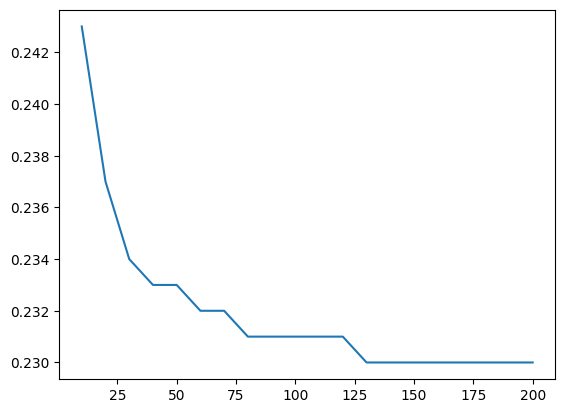

In [35]:
# INSPECTING THE RMSE SCORES:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

### Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [36]:
# TRAINING THE MODEL WITH DEPTH:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

100%|██████████| 4/4 [00:35<00:00,  8.87s/it]


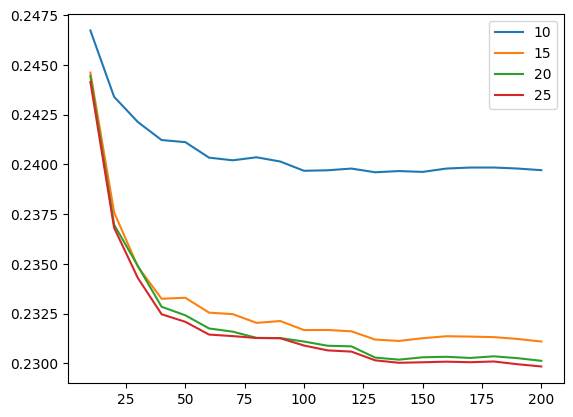

In [37]:
# PLOTTING THE GRAPH:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()